In [120]:
from keras.models import Sequential
from keras.layers import Dense, Input, Concatenate
from keras import Model
from tensorflow import keras

In [121]:
import os
import pandas as pd
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
def make_model():
  x = Input(shape=(60,), name="Game Play Data")
  y = Input(shape=(3,), name="Selected Character")
  g = Concatenate()([x, y])

  g = Dense(500, activation='relu', input_dim=8)(g)
  g = Dense(100, activation='relu')(g)
  g = Dense(50, activation='relu')(g)
  g = Dense(3, activation='softmax')(g)
  model = Model(inputs=[x, y], outputs=g)
  return model

In [123]:
opt = keras.optimizers.Adam()

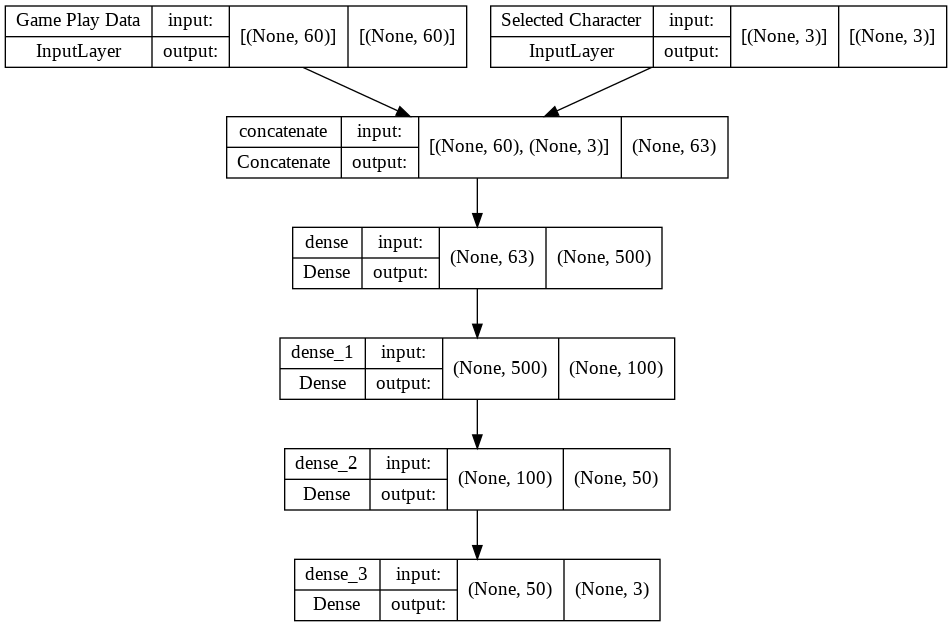

In [124]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [125]:
type_path = "sample_data/test_data"
graph_data = { }
game_play_data = { }
hash_data = {}
environments = {}

In [126]:
level_cap = 5
configuration_data = {}
reviews = { "27/07/2022 09:48:11": [0, 0, 1], "Test2": [0, 0, 1] }

In [127]:
for filename in os.listdir(type_path):
    file_path = os.path.join(type_path, filename)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        if "level_selection" in file_path:
            if filename not in hash_data:
                hash_data[filename] = []
                environments[filename] = {}
            for i in range(len(df)):
                battle_environment = df.loc[i, 'BattleEnvironment']
                battle_id = df.loc[i, 'ID']
                if battle_environment not in environments:
                    environments[filename][battle_environment] = [0, 0, 0, 0, 0]
                if battle_id not in hash_data:
                    level = df.loc[i, 'Level']
                    environments[filename][battle_environment][level] = environments[filename][battle_environment][level] + 1
                    hash_data[filename].append(battle_id)
        elif "level_configuration" in filename:
            for i in range(len(df)):
              config = df.iloc[i].values
              print(config)
              configuration_data[config[0]] = config[1:]
              configuration_data["1"] = config[1:]
        else:
            if filename not in game_play_data:
                game_play_data[filename] = {
                    "Brawler": {},
                    "Mage": {},
                    "Swordsman": {}
                }
                for key in game_play_data[filename]:
                    game_play_data[filename][key] = [[], [], [], [], []]
                graph_data[filename] = {}
            adventurer_type = filename.split('_')[0]
            for i in range(len(df)):
                level = df.loc[i, 'Level']
                max_steps = df.loc[i, 'MaxCount']
                game_play_data[filename][adventurer_type][level].append(max_steps)
            for key in game_play_data[filename]:
                graph_data[filename][key] = [[], [], [], [], []]
                for x in range(level_cap):
                    if len(game_play_data[filename][key][x]) > 0:
                        graph_data[filename][key][x] = mean(game_play_data[filename][key][x])

['27/07/2022 09:48:11' 0.9904898 0.8338813 1.099888]


In [128]:
print(configuration_data)
print(game_play_data)

{'27/07/2022 09:48:11': array([0.9904898, 0.8338813, 1.099888], dtype=object), '1': array([0.9904898, 0.8338813, 1.099888], dtype=object)}


In [143]:
from sklearn.model_selection import train_test_split
y = list(reviews.keys())
labels = []
labeled_config = []
for key in y:
  if key in configuration_data:
    data = configuration_data[key]
    labeled_config.append(data)
    labels.append(reviews[key])

unlabeled_data = []
for key in configuration_data:
  if key not in y:
    data = configuration_data[key]
    unlabeled_data.append(data)


In [144]:
print(labeled_config)
config.append(config[0])
print(labels)
labels.append(labels[0])
print(unlabeled_data)

[array([0.9904898, 0.8338813, 1.099888], dtype=object)]
[[0, 0, 1]]
[array([0.9904898, 0.8338813, 1.099888], dtype=object)]


In [139]:
train_data, train_labels, val_data, val_labels = train_test_split(config, labels, test_size=0.1)

In [140]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["categorical_accuracy"]
    val_accuracy = val_accuracy + history.history["val_categorical_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
def train_active_learning(
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=5000):
  # inspired from this https://keras.io/examples/nlp/active_learning_review_classification/
  model = make_model()
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],)
  losses, val_losses, accuracies, val_accuracies = [], [], [], []

  # Defining checkpoints.
  # The checkpoint callback is reused throughout the training since it only saves the best overall model.
  checkpoint = keras.callbacks.ModelCheckpoint(
      "AL_Model.h5", save_best_only=True, verbose=1
  )
  # Here, patience is set to 4. This can be set higher if desired.
  early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

  print(f"Starting to train with {len(train_dataset)} samples")
  # Initial fit with a small subset of the training set
  history = model.fit(
      x=train_data,
      y=train_labels,
      epochs=20,
      validation_data=(val_data, val_labels),
      callbacks=[checkpoint, early_stopping],
  )

  # Appending history
  losses, val_losses, accuracies, val_accuracies = append_history(
      losses, val_losses, accuracies, val_accuracies, history
  )

  for iteration in range(num_iterations):
      # Getting predictions from previously trained model
      predictions = model.predict(test_dataset)

      # Generating labels from the output probabilities
      rounded = tf.where(tf.greater(predictions, 0.5), 1, 0)

      # Evaluating the number of zeros and ones incorrrectly classified
      _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

      print("-" * 100)
      print(
          f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
      )

      # This technique of Active Learning demonstrates ratio based sampling where
      # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
      if false_negatives != 0 and false_positives != 0:
          total = false_negatives + false_positives
          sample_ratio_ones, sample_ratio_zeros = (
              false_positives / total,
              false_negatives / total,
          )
      # In the case where all samples are correctly predicted, we can sample both classes equally
      else:
          sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

      print(
          f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
      )

      # Sample the required number of ones and zeros
      sampled_dataset = pool_negatives.take(
          int(sample_ratio_zeros * sampling_size)
      ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

      # Skip the sampled data points to avoid repetition of sample
      pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
      pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

      # Concatenating the train_dataset with the sampled_dataset
      train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
          tf.data.AUTOTUNE
      )

      print(f"Starting training with {len(train_dataset)} samples")
      print("-" * 100)

      # We recompile the model to reset the optimizer states and retrain the model
      model.compile(
          loss="binary_crossentropy",
          optimizer="rmsprop",
          metrics=[
              keras.metrics.BinaryAccuracy(),
              keras.metrics.FalseNegatives(),
              keras.metrics.FalsePositives(),
          ],
      )
      history = model.fit(
          train_dataset.cache().shuffle(20000).batch(256),
          validation_data=val_dataset,
          epochs=20,
          callbacks=[
              checkpoint,
              keras.callbacks.EarlyStopping(patience=4, verbose=1),
          ],
      )

      # Appending the history
      losses, val_losses, accuracies, val_accuracies = append_history(
          losses, val_losses, accuracies, val_accuracies, history
      )

      # Loading the best model from this training loop
      model = keras.models.load_model("AL_Model.h5")

      # Plotting the overall history and evaluating the final model
  plot_history(losses, val_losses, accuracies, val_accuracies)
  print("-" * 100)
  print(
      "Test set evaluation: ",
      model.evaluate(test_dataset, verbose=0, return_dict=True),
  )
  print("-" * 100)

  return model